<a href="https://colab.research.google.com/github/aranciazrr/For-College/blob/main/BigData_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SET UP

In [ ]:
# Instalasi PySpark
!pip install -q pyspark

In [ ]:
# Instalasi library Kaggle
!pip install -q kaggle

In [ ]:
import os
from google.colab import files
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid")

IMPORT DATASET

In [ ]:
os.environ['KAGGLE_USERNAME'] = "hurinazzahro"
os.environ['KAGGLE_KEY'] = "KGAT_7fc890604190d5aefe9a341a6ca03e79"

In [ ]:
!kaggle datasets download -d carrie1/ecommerce-data
!unzip -o ecommerce-data.zip

print("Dataset berhasil diunduh")

Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown
  0% 0.00/7.20M [00:00<?, ?B/s]
100% 7.20M/7.20M [00:00<00:00, 774MB/s]
Archive:  ecommerce-data.zip
  inflating: data.csv                
Dataset berhasil diunduh


CREATE SESSION

In [ ]:
spark = SparkSession.builder.appName("BigData_Processing").getOrCreate()

PEMROSESAN DATA

In [ ]:
df = spark.read.csv('data.csv', header=True, inferSchema=True)

In [ ]:
# data cleaning
df_clean = df.filter((F.col("CustomerID").isNotNull()) & (F.col("Quantity") > 0))
# customer id tidak boleh kosong dan quantity harus bernilai positif (>0)

In [ ]:
# Menambahkan kolom TotalPrice (Price * Quantity)
df_final = df_clean.withColumn("TotalPrice", F.col("Quantity") * F.col("UnitPrice"))

Beberapa penyesuaian nama kolom berdasarkan dataset yang didapat dari kaggle.com:

*   `InvoiceNo` sebagai `transaction_id` atau ID transaksi
*   `CustomerID` sebagai `customer_id`atau ID pelanggan
*   `StockCode` sebagai `product_id`atau ID produk
*   `UnitPrice` sebagai `price`atau Harga produk
*   `InvoiceDate` sebagai `timestamp`atau Waktu transaksi









In [ ]:
print("10 data teratas setelah perubahan:")
df_final.select("InvoiceNo", "CustomerID", "StockCode", "Description", "UnitPrice", "TotalPrice", "Quantity", "InvoiceDate").show(10)

10 data teratas setelah perubahan:
+---------+----------+---------+--------------------+---------+------------------+--------+--------------+
|InvoiceNo|CustomerID|StockCode|         Description|UnitPrice|        TotalPrice|Quantity|   InvoiceDate|
+---------+----------+---------+--------------------+---------+------------------+--------+--------------+
|   536365|     17850|   85123A|WHITE HANGING HEA...|     2.55|15.299999999999999|       6|12/1/2010 8:26|
|   536365|     17850|    71053| WHITE METAL LANTERN|     3.39|             20.34|       6|12/1/2010 8:26|
|   536365|     17850|   84406B|CREAM CUPID HEART...|     2.75|              22.0|       8|12/1/2010 8:26|
|   536365|     17850|   84029G|KNITTED UNION FLA...|     3.39|             20.34|       6|12/1/2010 8:26|
|   536365|     17850|   84029E|RED WOOLLY HOTTIE...|     3.39|             20.34|       6|12/1/2010 8:26|
|   536365|     17850|    22752|SET 7 BABUSHKA NE...|     7.65|              15.3|       2|12/1/2010 8:26|
| 

In [ ]:
# Menentukan pelanggan dengan jumlah pembelian tertinggi

# Pembelian berdasarkan kuantitas barang
TopQTY = df_final.groupBy("CustomerID") \
    .agg(F.sum("Quantity").alias("TotalUnit")) \
    .orderBy(F.desc("TotalUnit"))

# Pembelian berdasarkan nilai pembelian
TopPrice = df_final.groupBy("CustomerID") \
    .agg(F.sum("TotalPrice").alias("TotalSpending")) \
    .orderBy(F.desc("TotalSpending"))

In [ ]:
print("Pelanggan dengan Jumlah Pembelian Tertinggi (Berdasarkan Unit Barang):")
TopQTY.show(5)

print("Pelanggan dengan Jumlah Pembelian Tertinggi (Berdasarkan Nilai Pembelian Tertinggi):")
TopPrice.show(5)

Pelanggan dengan Jumlah Pembelian Tertinggi (Berdasarkan Unit Barang):
+----------+---------+
|CustomerID|TotalUnit|
+----------+---------+
|     14646|   197491|
|     16446|    80997|
|     14911|    80515|
|     12415|    77670|
|     12346|    74215|
+----------+---------+
only showing top 5 rows
Pelanggan dengan Jumlah Pembelian Tertinggi (Berdasarkan Nilai Pembelian Tertinggi):
+----------+------------------+
|CustomerID|     TotalSpending|
+----------+------------------+
|     14646| 280206.0199999994|
|     18102|259657.29999999996|
|     17450|194550.78999999995|
|     16446|          168472.5|
|     14911|143825.05999999982|
+----------+------------------+
only showing top 5 rows


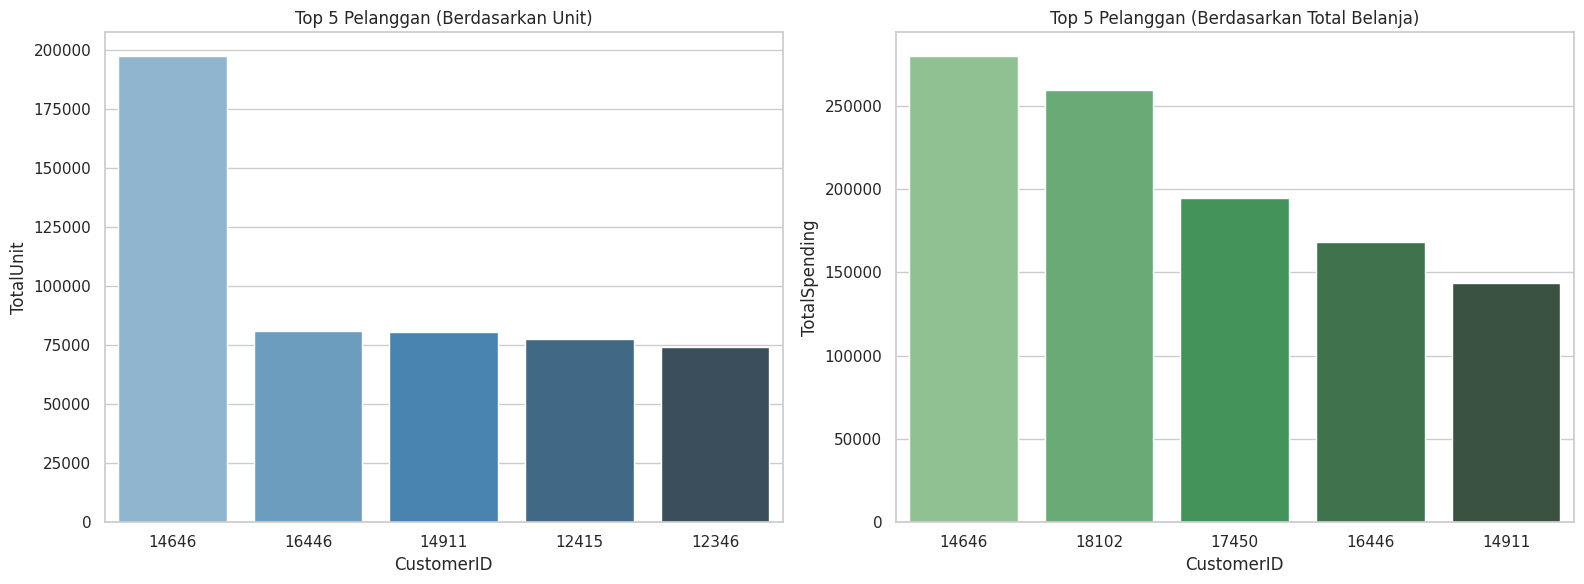

In [ ]:
# Visualisasi Data

# Konversi data ke Pandas
pdf_qty = TopQTY.limit(5).toPandas()
pdf_price = TopPrice.limit(5).toPandas()

pdf_qty['CustomerID'] = pdf_qty['CustomerID'].astype(str)
pdf_price['CustomerID'] = pdf_price['CustomerID'].astype(str)

# Membuat 2 grafik berdampingan
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Grafik A: Berdasarkan Unit
sns.barplot(x='CustomerID', y='TotalUnit', data=pdf_qty, ax=ax[0],
            hue='CustomerID', palette='Blues_d', legend=False)
ax[0].set_title('Top 5 Pelanggan (Berdasarkan Unit)', fontsize=12)

# Grafik B: Berdasarkan Nilai Pembelian
sns.barplot(x='CustomerID', y='TotalSpending', data=pdf_price, ax=ax[1],
            hue='CustomerID', palette='Greens_d', legend=False)
ax[1].set_title('Top 5 Pelanggan (Berdasarkan Total Belanja)', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Mengidentifikasi produk yang paling sering dibeli
TopProduct = df_final.groupBy("StockCode", "Description") \
    .agg(F.sum("Quantity").alias("TotalQuantitySold")) \
    .orderBy(F.desc("TotalQuantitySold"))

print("Top 5 Produk yang Paling Sering Dibeli")
TopProduct.show(5, truncate=False)

Top 5 Produk yang Paling Sering Dibeli
+---------+----------------------------------+-----------------+
|StockCode|Description                       |TotalQuantitySold|
+---------+----------------------------------+-----------------+
|23843    |PAPER CRAFT , LITTLE BIRDIE       |80995            |
|23166    |MEDIUM CERAMIC TOP STORAGE JAR    |77916            |
|84077    |WORLD WAR 2 GLIDERS ASSTD DESIGNS |54415            |
|85099B   |JUMBO BAG RED RETROSPOT           |46181            |
|85123A   |WHITE HANGING HEART T-LIGHT HOLDER|36725            |
+---------+----------------------------------+-----------------+
only showing top 5 rows


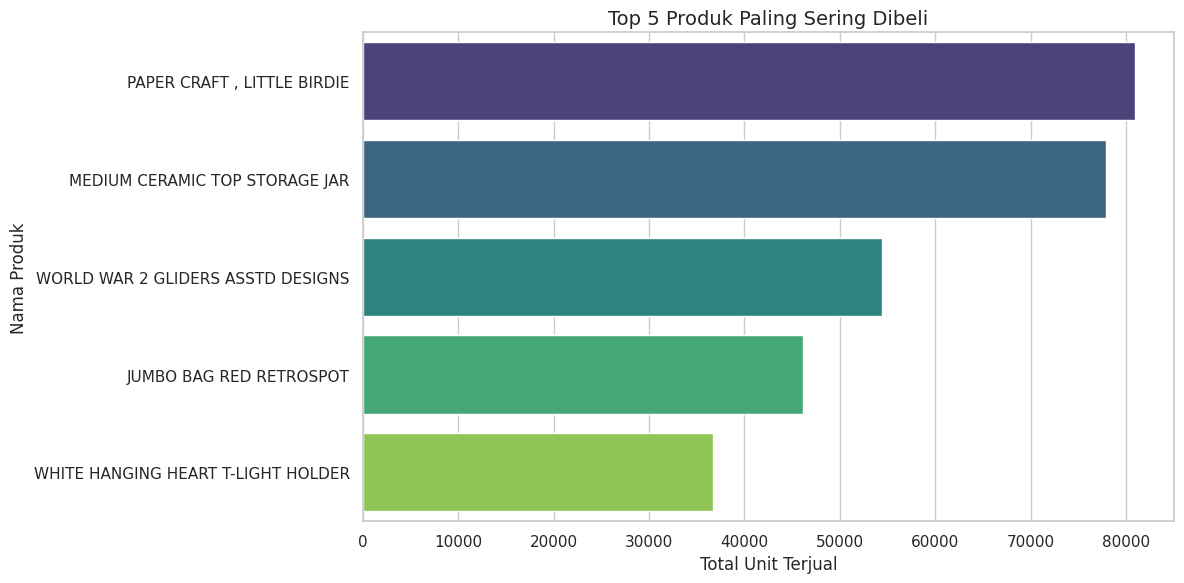

In [ ]:
# Visualisasi Data

# Konversi hasil TopProduct ke Pandas
pdf_products = TopProduct.limit(5).toPandas()

plt.figure(figsize=(12, 6))

sns.barplot(x='TotalQuantitySold', y='Description', data=pdf_products,
            hue='Description', palette='viridis', legend=False)

plt.title('Top 5 Produk Paling Sering Dibeli', fontsize=14)
plt.xlabel('Total Unit Terjual')
plt.ylabel('Nama Produk')
plt.tight_layout()
plt.show()

Kesimpulan:

1.   Total Pendapatan Perusahaan sebesar `8,911,407.90`.
2.   Pelanggan dengan jumlah pembelian tertinggi adalah `Customer` dengan ID `14646` dengan `TotalUnit` sebanyak `197491` dan `TotalSpending` sebesar `280206.0199999994`.
1.   `Produk` yang paling sering dibeli adalah `PAPER CRAFT , LITTLE BIRDIE` (ID Product: `23843`) dengan total unit terjual sebanyak `80995`.






